# Tabular models

In [1]:
from fastai import *
from fastai.tabular import *

Tabular data should be in a Pandas `DataFrame`.

In [2]:
import os
import re
from collections import Counter
import random

In [3]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
path = '/floyd/home/notebooks'
data_path = '/floyd/home/data'
model_path = '/floyd/home/models'

In [6]:
os.listdir(data_path)

['tabular_data.csv',
 'ed_databunch',
 '.ipynb_checkpoints',
 'targets.csv',
 'subj_data.csv',
 'date_data.csv',
 'jj_modified_bch_data.xlsx',
 'inf_control_data.csv']

In [8]:
df1 = pd.read_csv(data_path +'/tabular_data.csv')
df2 = pd.read_csv(data_path +'/targets.csv')
df3 = pd.read_csv(data_path + '/subj_data.csv')
df = pd.concat([df1,df2,df3], axis = 1)

In [9]:
len(df)

136993

In [10]:
df.head()

,Unnamed: 0,ID,TriageLevel,AgeInYrs,GenderDesc,DischargeDisposition,PresentingComplaint,PresentingComplaintDesc,AdmitLocation,PatientService,...,Unnamed: 0,service,target2,target,outcome,discharge,dispo,Unnamed: 0,MedicalHistory,SubjectiveNotes
0,0,1,3.0,12.0,Male,17,852,Fever,NaN,NaN,...,0,discharge,1,1,discharge,1,NaN,0,NaN,NaN
1,1,2,2.0,80.0,Female,17,401,Altered level of consciousness,NaN,NaN,...,1,discharge,1,1,discharge,1,NaN,1,NaN,NaN
2,2,3,3.0,3.0,Male,17,253,Constipation,NaN,NaN,...,2,discharge,1,1,discharge,1,NaN,2,NaN,NaN
3,3,4,3.0,56.0,Female,62,409,Extremity weakness/symptoms of CVA,NaN,NaN,...,3,discharge,1,1,discharge,1,NaN,3,NaN,NaN
4,4,5,2.0,69.0,Female,17,3,Chest pain - cardiac features,NaN,NaN,...,4,discharge,1,1,discharge,1,NaN,4,NaN,NaN


In [11]:
list(df.columns)

['Unnamed: 0',
 'ID',
 'TriageLevel',
 'AgeInYrs',
 'GenderDesc',
 'DischargeDisposition',
 'PresentingComplaint',
 'PresentingComplaintDesc',
 'AdmitLocation',
 'PatientService',
 'BloodPressure_LastEDReading',
 'systolic',
 'diastolic',
 'temp',
 'pulse',
 'o2sat',
 'Unnamed: 0',
 'service',
 'target2',
 'target',
 'outcome',
 'discharge',
 'dispo',
 'Unnamed: 0',
 'MedicalHistory',
 'SubjectiveNotes']

In [12]:
#check that I got what I wanted out of the prior setp
count = Counter(df['outcome']); count

Counter({'discharge': 120106, 'sadmit': 2272, 'madmit': 13270, 'ICU': 1345})

In [13]:
dep_var = 'outcome'
cat_names = ['TriageLevel',
 'GenderDesc',
 'PresentingComplaint']
cont_names = ['AgeInYrs', 'o2sat', 'pulse','temp','systolic','diastolic']
procs = [FillMissing, Categorify, Normalize]

In [14]:
test = TabularList.from_df(df.copy(),cat_names=cat_names, cont_names=cont_names)

In [15]:
valid_idxs = random.sample(range(len(df)), len(df)//5); len(valid_idxs)

27398

In [34]:
data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idxs)
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

In [22]:
len(data.train_ds), len(data.valid_ds)

(109595, 27398)

In [23]:
len(data.train_ds) +  len(data.valid_ds) == len(data.test_ds)

True

In [24]:
data.save(data_path + '/ed_databunch')

In [25]:
data.show_batch(rows=10)

TriageLevel,GenderDesc,PresentingComplaint,o2sat_na,pulse_na,temp_na,systolic_na,diastolic_na,AgeInYrs,o2sat,pulse,temp,systolic,diastolic,target
2.0,Female,301,False,False,False,False,False,0.5689,-0.2583,0.1498,-0.2276,1.2221,0.5450,discharge
3.0,Male,852,False,False,False,True,True,-1.6620,0.3022,1.9023,2.7299,-0.1164,-0.0549,discharge
3.0,Male,551,False,False,False,False,False,1.1092,0.0219,-1.0320,-0.4125,0.1067,-0.0549,discharge
2.0,Male,504,False,False,False,False,False,1.7327,-0.5386,0.3536,-0.0428,1.7128,-0.0549,discharge
3.0,Female,257,False,False,False,False,False,-0.4703,0.5824,-0.9505,-0.0428,-0.3394,0.6950,discharge
5.0,Male,719,False,False,False,False,False,-0.6781,0.5824,-0.3800,0.1421,-0.5179,0.0201,discharge
2.0,Female,551,False,False,False,False,False,0.0701,0.5824,-0.2170,-1.1519,-0.6071,-0.5048,discharge
3.0,Male,752,False,False,False,False,False,-1.6342,0.0219,1.0057,-0.4125,-1.5440,-1.2546,discharge
3.0,Male,852,False,False,False,False,False,-1.5095,0.3022,1.9838,4.0238,-1.4994,-1.7795,discharge
3.0,Male,151,False,False,False,False,False,0.9430,-0.5386,-0.7875,-0.7822,0.5082,0.6950,discharge


In [18]:
f1 = FBeta(beta=1, average = 'weighted')

In [27]:
learn = tabular_learner(data, layers=[200,100], metrics=[accuracy,f1])

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


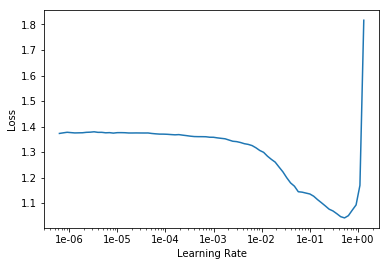

In [29]:
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(5, 1e-1)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.374371,0.381770,0.881086,0.837814,00:18
1,0.370919,2.424722,0.886050,0.850599,00:18
2,0.353213,0.478033,0.885503,0.851544,00:18
3,0.327756,0.350664,0.885612,0.849811,00:18
4,0.333046,0.357082,0.888094,0.857315,00:18


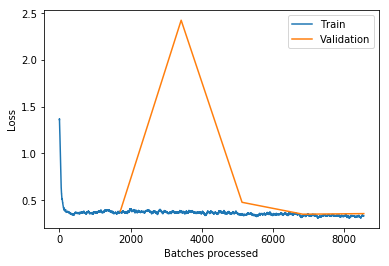

In [31]:
learn.recorder.plot_losses()

In [32]:
learn = tabular_learner(data, layers=[200,100], metrics=[accuracy,f1])
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.333169,0.344693,0.884809,0.851478,00:18
1,0.354932,0.342966,0.886196,0.856591,00:18
2,0.334693,0.341903,0.887255,0.857294,00:18
3,0.334851,0.336169,0.887985,0.859119,00:18
4,0.338736,0.342084,0.887437,0.853416,00:18
5,0.344477,0.338685,0.886525,0.852332,00:18
6,0.331653,0.335892,0.887839,0.858500,00:18
7,0.324366,0.330495,0.888459,0.859923,00:18
8,0.334767,0.336139,0.888714,0.862758,00:18
9,0.335335,0.332870,0.888678,0.858748,00:18


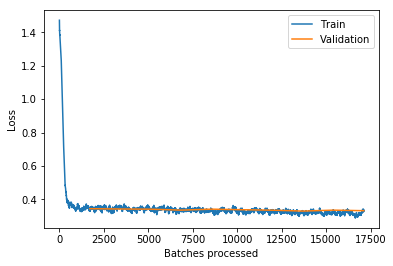

In [33]:
learn.recorder.plot_losses()

In [36]:
preds, targets = learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1)

In [45]:
preds[0], targets[0], predictions[0]

(tensor([0.0014, 0.9312, 0.0562, 0.0112]), tensor(1), tensor(1))

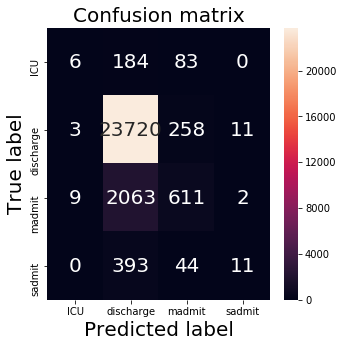

In [42]:
LABELS = data.classes

confusion_matrix = sklearn.metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [47]:
f1_w = sklearn.metrics.f1_score(targets, predictions, average='weighted')
f1 = sklearn.metrics.f1_score(targets, predictions, average=None)
acc = sklearn.metrics.accuracy_score(targets, predictions)
prec = sklearn.metrics.precision_score(targets,predictions, average = None)
rec = sklearn.metrics.recall_score(targets,predictions, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)

weighted f1:  0.8587475758612368
f1:           [0.041237 0.942167 0.331975 0.04661 ]
accuracy:     0.8886780056938463
precision:    [0.333333 0.899848 0.613454 0.458333]
recall:       [0.021978 0.988663 0.227561 0.024554]


In [35]:
learn = tabular_learner(data, layers=[200,100], metrics=[accuracy,f1])

In [36]:
learn.fit_one_cycle(5, 1e-3)

AttributeError: 'numpy.ndarray' object has no attribute '__name__'

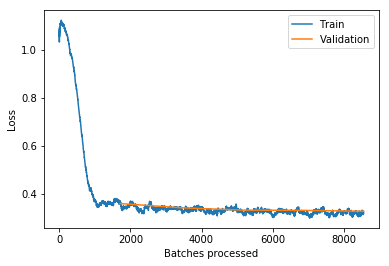

In [22]:
learn.recorder.plot_losses()

In [23]:
preds, targets = learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1)

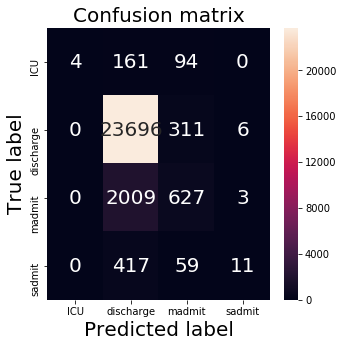

In [24]:
LABELS = data.classes

confusion_matrix = sklearn.metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [25]:
f1_w = sklearn.metrics.f1_score(targets, predictions, average='weighted')
f1 = sklearn.metrics.f1_score(targets, predictions, average=None)
acc = sklearn.metrics.accuracy_score(targets, predictions)
prec = sklearn.metrics.precision_score(targets,predictions, average = None)
rec = sklearn.metrics.recall_score(targets,predictions, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)

weighted f1:  0.8592874197852992
f1:           [0.030418 0.942262 0.336193 0.043393]
accuracy:     0.8883130155485802
precision:    [1.       0.901571 0.574702 0.55    ]
recall:       [0.015444 0.986799 0.23759  0.022587]


Now gonna try to do better by adding some columns that are from the triage notes

In [40]:
from fastai.text import *

In [41]:
data_lm2 = load_data(model_path, 'large_lm')
data_clas2 = load_data(model_path, 'large_clas_db')

In [42]:
model = text_classifier_learner(data_clas2, arch = AWD_LSTM, drop_mult=0.5)

In [44]:
model.load(model_path + '/edtriage1');